# Building models to compare two treatments for prostatic cancer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2
from lifelines import CoxPHFitter

Read the data

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Comparison of two treatments for prostatic cancer.dat", sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3833/1212411937.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Comparison of two treatments for prostatic cancer.dat", sep="\s+")


In [ ]:
DatOriginal.head()

Treatment 1 means that the patient was treated with a placebo and 2 means that was treated with DES.

---

Function that calculates the test stadistic and $P$-value to compare two nested models based on the log-likelihood ratio test.

In [4]:
def LoglikeRatioTest(minus2loglike_model1, minus2loglike_model2, df_model1, df_model2):
    # model1 must be nested in model2, i.e. model2 has more variables than model1
    test_statistic = minus2loglike_model1 - minus2loglike_model2
    p_value = chi2.sf(test_statistic, df_model2-df_model1)
    return test_statistic, p_value

---

The data only has four prognostic variables: age, shb, size, and index.

We can create a model for each possible combination of these variables, i.e., we can build 16 models.

In [6]:
formulas = [
    'age', 'shb', 'size', 'index',
    'age+shb', 'age+size', 'age+index', 'shb+size', 'shb+index', 'size+index',
    'age+shb+size', 'age+shb+index', 'age+size+index', 'shb+size+index',
    'age+shb+size+index'
]

MinusTwoLogLike = []
Aic = []
DegreesFreedom = []

for i,f in enumerate(formulas):

    cph = CoxPHFitter()
    Model = cph.fit(DatOriginal, 'time', 'status', formula=f)

    if i==0:
        _ = -2*Model.log_likelihood_ + Model.log_likelihood_ratio_test().test_statistic
        MinusTwoLogLike.append(_)
        DegreesFreedom.append(0)
        Aic.append(_)

    MinusTwoLogLike.append(-2*Model.log_likelihood_)
    DegreesFreedom.append(len(Model.summary))
    Aic.append(Model.AIC_partial_)

formulas.insert(0, 'None')

ModelSummary = pd.DataFrame({'formula': formulas, '-2log-L': MinusTwoLogLike, 'AIC': Aic, 'df': DegreesFreedom})

We can simply select the model with the smallest AIC.

In [9]:
ModelSummary[ModelSummary['AIC'] == ModelSummary['AIC'].min()]

,formula,-2log-L,AIC,df
10,size+index,23.533263,27.533263,2


---

Alternatevely, we can follow the next strategy if we have several variables.

1. First we fit models that contain each of the variables at a time. The variables that appear important, compared to the Null model are then consider in the subsequent step.

In [25]:
ModelSummary.round(3)

,formula,-2log-L,AIC,df
0,None,36.349,36.349,0
1,age,36.269,38.269,1
2,shb,36.196,38.196,1
3,size,29.042,31.042,1
4,index,29.127,31.127,1
5,age+shb,36.151,40.151,2
6,age+size,28.854,32.854,2
7,age+index,28.760,32.760,2
8,shb+size,29.019,33.019,2
9,shb+index,27.981,31.981,2


In [11]:
PValues = []

for i in [1,2,3,4]:
    _, Pvalue = LoglikeRatioTest(ModelSummary.loc[0]['-2log-L'], ModelSummary.loc[i]['-2log-L'], 0, ModelSummary.loc[i]['df'])
    PValues.append(Pvalue)

np.round(PValues,3)

[0.7779911444935175,
 0.6955516002667974,
 0.006867314540372138,
 0.007202147273535943]

From the previous $P$-values we deduce that only size and index appear to be important.

2. The variables that appear to be important from step 1 are then fitted together. In the presence of certain variables, others may cease to be important. Those that do not lead to a significant increase in the value of $-2\log \hat{L}$ when omittted can be discarded.

In [12]:
# Comparing model size+index against model size, i.e. omitting index
np.round(LoglikeRatioTest(
    ModelSummary.loc[3]['-2log-L'],
    ModelSummary.loc[10]['-2log-L'],
    ModelSummary.loc[3]['df'],
    ModelSummary.loc[10]['df']
),3)
# index should not be omitted

(5.508301207881683, 0.018926421220873194)

In [13]:
# Comparing model size+index against model index, i.e. omitting size
np.round(LoglikeRatioTest(
    ModelSummary.loc[4]['-2log-L'],
    ModelSummary.loc[10]['-2log-L'],
    ModelSummary.loc[4]['df'],
    ModelSummary.loc[10]['df']
),3)
# size should not be omitted

(5.593801447948362, 0.018024138784460835)

We can deduce from this analysis that both variables are needed.

3. Variables that were not important on their own may become important in the presence of others. We added such variables one at a time to our model. Those that reduce $-2\log\hat{L}$ significantly are retained in the model.

In [14]:
# Comparing model size+index against model size+index+age, i.e. adding age
np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    ModelSummary.loc[13]['-2log-L'],
    ModelSummary.loc[10]['df'],
    ModelSummary.loc[13]['df']
),3)
# age should not be added

(0.2639117510255282, 0.6074453762736507)

In [15]:
# Comparing model size+index against model size+index+age, i.e. adding shb
np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    ModelSummary.loc[14]['-2log-L'],
    ModelSummary.loc[10]['df'],
    ModelSummary.loc[14]['df']
),3)
# shb should not be added

(0.02524615760133031, 0.8737552282937574)

We now consider the treatment effect, and observe if it is significant.

In [16]:
cph = CoxPHFitter()
ModelTreat = cph.fit(DatOriginal, 'time', 'status', formula='size+index+C(treatment)')

np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    -2*ModelTreat.log_likelihood_,
    ModelSummary.loc[10]['df'],
    len(ModelTreat.summary)
),3)

(0.9609384183216783, 0.3269505571758091)

If the possibility of interactions between the treatment and other explanatory variables has not been discounted, these must be considered before the treatment effect can be interpreted

In [17]:
cph = CoxPHFitter()
ModelTsize = cph.fit(DatOriginal, 'time', 'status', formula='size+index+C(treatment)+size*C(treatment)')

np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    -2*ModelTsize.log_likelihood_,
    ModelSummary.loc[10]['df'],
    len(ModelTsize.summary)
),3)

(2.704531810062317, 0.2586535118445922)

In [19]:
cph = CoxPHFitter()
ModelTindex = cph.fit(DatOriginal, 'time', 'status', formula='size+index+C(treatment)+index*C(treatment)')

np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    -2*ModelTindex.log_likelihood_,
    ModelSummary.loc[10]['df'],
    len(ModelTindex.summary)
),3)

/home/dmitri/.local/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


(1.76222161761849, 0.4143224229741673)

In [20]:
cph = CoxPHFitter()
ModelTsizeTindex = cph.fit(DatOriginal, 'time', 'status', formula='size+index+C(treatment)+size*C(treatment)+index*C(treatment)')

np.round(LoglikeRatioTest(
    ModelSummary.loc[10]['-2log-L'],
    -2*ModelTsizeTindex.log_likelihood_,
    ModelSummary.loc[10]['df'],
    len(ModelTsizeTindex.summary)
),3)

/home/dmitri/.local/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


(3.593507091854004, 0.3088355255951053)

We conclude that treatment with DES does not appear to affect the hazard of death.

---

Notice that we receive a warning message of not convergence of Newton-Raphson. If we plot the models, we will observe that they are overfitted. So we should not include the mixed terms. These is because in the data there are only 6 confirmed deaths.

In [21]:
DatOriginal.status.sum()

6

<Axes: xlabel='log(HR) (95% CI)'>

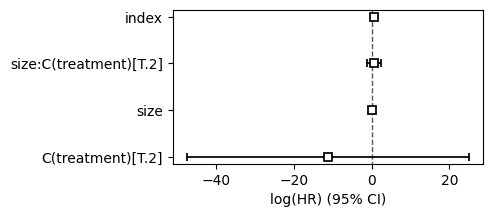

In [22]:
plt.figure(figsize=(4,2))
ModelTsize.plot()

<Axes: xlabel='log(HR) (95% CI)'>

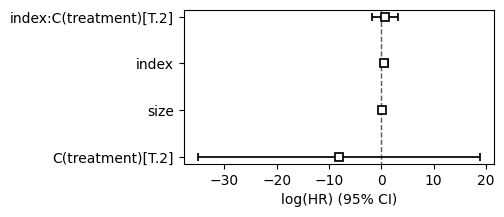

In [23]:
plt.figure(figsize=(4,2))
ModelTindex.plot()

<Axes: xlabel='log(HR) (95% CI)'>

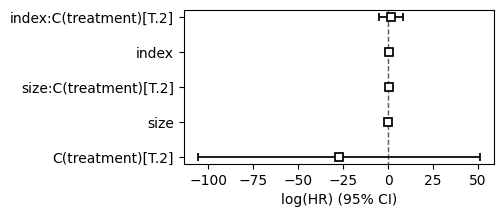

In [24]:
plt.figure(figsize=(4,2))
ModelTsizeTindex.plot()